plot chromHMM

In [28]:
# python modules
import copy
import re
import random
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
from scipy import stats


In [29]:
# custom modules
import graphics_edit as graphics
import load_file_edit as load_file
import Interval_dict
import statis_edit as statis


In [30]:
# matplotlib setting
%matplotlib inline
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"


In [31]:
### parameters
cell_org = {'H1':'human',
            'GM':'human',
            'mCD8T:WT':'mouse',
            'mCD8T:DFMO':'mouse',
            'mCD8T:ODCKO':'mouse'}

cell_chrnames = {'H1':['chr%s' % (i) for i in range(1, 23)] + ['chrX', 'chrY'],
                 'GM':['chr%s' % (i) for i in range(1, 23)] + ['chrX'],
                 'mCD8T:WT':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:DFMO':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:ODCKO':['chr%s' % (i) for i in range(1, 20)] + ['chrX']}


In [32]:
agent_fullname = {'sp':'Spermine(4+)',
                  'spd':'Spermidine(3+)',
                  'CoH':'Cobalt Hexammine(3+)',
                  'PEG':'PEG 8000',
                  'HP1a':'HP1$\\alpha$',
                  'HP1bSUV':'HP1$\\beta$+tSUV',
                  'LKH':'Linker histone1',
                  'Ki67':'Ki67',
                  'FUS':'FUS',
                  'Mg':'Magnesium',
                  'Ca':'Calcium'}


In [33]:
## for H1
H1_name_dict = {"E1":"Polycomb repressed",
                "E2":"Poised promoter",
                "E3":"Weak promoter",
                "E4":"Strong enhancer",
                "E5":"Active promoter",
                "E6":"Weak enhancer",
                "E7":"Quiescence1",
                "E8":"Quiescence2",
                "E9":"Heterochromatin",
                "E10":"Tx elongation",
                "E11":"Weak Tx",
                "E12":"Insulator"}

# state for H1
H1_states = ["Active promoter", "Weak promoter", "Poised promoter", "Strong enhancer", "Weak enhancer", "Tx elongation", "Weak Tx", "Insulator", "Polycomb repressed", "Heterochromatin", "Quiescence1", "Quiescence2"]

H1_HMM_fname = "H1_12_segments.bed"


In [34]:
# for GM12878
GM_name_dict = {"E1":"Polycomb repressed",
                "E2":"Quiescence",
                "E3":"Heterochromatin",
                "E4":"Weak Tx",
                "E5":"Tx elongation",
                "E6":"Weak enhancer",
                "E7":"Active enhancer",
                "E8":"Strong enhancer",
                "E9":"Active promoter",
                "E10":"Weak promoter",
                "E11":"Poised promoter",
                "E12":"Insulator"}

# state for GM
GM_states = ["Active promoter", "Weak promoter", "Poised promoter", "Strong enhancer", "Active enhancer", "Weak enhancer", "Tx elongation", "Weak Tx", "Insulator", "Polycomb repressed", "Heterochromatin", "Quiescence"]

GM_HMM_fname = "GM12878_12_segments.bed"


In [35]:
# for mouse CD8 T cell
mCD8T_name_dict = {"E1":"Weak Tx",
                   "E2":"Tx elongation",
                   "E3":"Weak enhancer2",
                   "E4":"Strong enhancer2",
                   "E5":"Strong enhancer1",
                   "E6":"Weak enhancer1",
                   "E7":"Active promoter",
                   "E8":"Poised promoter",
                   "E9":"Polycomb repressed1",
                   "E10":"Polycomb repressed2",
                   "E11":"Quiescence",
                   "E12":"Heterochromatin"}

# state for mouse CD8 T cell
mCD8T_states = ["Active promoter", "Poised promoter", "Strong enhancer1", "Strong enhancer2", "Weak enhancer1", "Weak enhancer2", "Tx elongation", "Weak Tx", "Polycomb repressed1", "Polycomb repressed2", "Heterochromatin", "Quiescence"]

mCD8T_HMM_fname = "Mouse CD8 T cell (invitro activated)_12_segments.bed"


In [36]:
# data path
#path = './data/'
path = '/Users/sangwoopark/jhu_rockfish/2024_01_05_GEO/processed_files/'
chromHMM_path = '/Users/sangwoopark/jhu_rockfish/chromHMM_data/'

In [37]:
# chromHMM data set
cell_chromHMM = {'H1':[H1_HMM_fname, H1_name_dict, H1_states],
                 'GM':[GM_HMM_fname, GM_name_dict, GM_states],
                 'mCD8T':[mCD8T_HMM_fname, mCD8T_name_dict, mCD8T_states]}


In [38]:
### set data information (fname/field) and key
#gtab_path = '/Users/sangwoopark/jhu_rockfish/MouseEpigeneticData/ODC_mouse_HistoneChipseq/'
path = '/Users/sangwoopark/jhu_rockfish/2024_01_05_GEO/processed_files/'

#dinfo_dkey = {'mCD8T:WT_NCP_sp_1rep_deep_chr([0-9XY])+_score_table.gtab.gz':
#              {'H3K27ac_new_1rep':(1, 'mCD8T:WT', 'H3K27ac'),
#               'H3K27ac_new_2rep':(2, 'mCD8T:WT', 'H3K27ac'),
#               'H3K27ac_new_3rep':(3, 'mCD8T:WT', 'H3K27ac'),
#               'H3K27me3_new_1rep':(1, 'mCD8T:WT', 'H3K27me3'),
#               'H3K27me3_new_2rep':(2, 'mCD8T:WT', 'H3K27me3'),
#               'H3K27me3_new_3rep':(3, 'mCD8T:WT', 'H3K27me3')},
#              'mCD8T:DFMO_NCP_sp_1rep_deep_chr([0-9XY])+_score_table.gtab.gz':
#              {'H3K27ac_new_1rep':(1, 'mCD8T:DFMO', 'H3K27ac'),
#               'H3K27ac_new_2rep':(2, 'mCD8T:DFMO', 'H3K27ac'),
#               'H3K27ac_new_3rep':(3, 'mCD8T:DFMO', 'H3K27ac'),
#               'H3K27me3_new_1rep':(1, 'mCD8T:DFMO', 'H3K27me3'),
#               'H3K27me3_new_2rep':(2, 'mCD8T:DFMO', 'H3K27me3'),
#               'H3K27me3_new_3rep':(3, 'mCD8T:DFMO', 'H3K27me3')}}

#dinfo_dkey = {'mCD8T:WT_NCP_sp_1rep_deep_chr1_score_table.gtab.gz':
#              {'H3K27ac_new_1rep':(1, 'mCD8T:WT', 'H3K27ac'),
#               'H3K27ac_new_2rep':(2, 'mCD8T:WT', 'H3K27ac'),
#               'H3K27ac_new_3rep':(3, 'mCD8T:WT', 'H3K27ac'),
#               'H3K27me3_new_1rep':(1, 'mCD8T:WT', 'H3K27me3'),
#               'H3K27me3_new_2rep':(2, 'mCD8T:WT', 'H3K27me3'),
#               'H3K27me3_new_3rep':(3, 'mCD8T:WT', 'H3K27me3'),
#               'mCD8T:WT_NCP_sp_8_1rep_deep':(1, 'mCD8T:WT', 'score')},
#              'mCD8T:DFMO_NCP_sp_1rep_deep_chr1_score_table.gtab.gz':
#              {'H3K27ac_new_1rep':(1, 'mCD8T:DFMO', 'H3K27ac'),
#               'H3K27ac_new_2rep':(2, 'mCD8T:DFMO', 'H3K27ac'),
#               'H3K27ac_new_3rep':(3, 'mCD8T:DFMO', 'H3K27ac'),
#               'H3K27me3_new_1rep':(1, 'mCD8T:DFMO', 'H3K27me3'),
#               'H3K27me3_new_2rep':(2, 'mCD8T:DFMO', 'H3K27me3'),
#               'H3K27me3_new_3rep':(3, 'mCD8T:DFMO', 'H3K27me3'),
#               'mCD8T:DFMO_NCP_sp_8_1rep_deep':(1, 'mCD8T:DFMO', 'score')}
#              }

dinfo_dkey = {'mCD8T:WT_NCP_sp_1rep_deep_chr1_score_table.gtab.gz':
              {'mCD8T:WT_NCP_sp_8_1rep_deep':(1, 'mCD8T:WT', 'score')},
              'mCD8T:DFMO_NCP_sp_1rep_deep_chr1_score_table.gtab.gz':
              {'mCD8T:DFMO_NCP_sp_8_1rep_deep':(1, 'mCD8T:DFMO', 'score')},
              'mCD8T:ODCKO_NCP_sp_1rep_deep_chr1_score_table.gtab.gz':
              {'mCD8T:ODCKO_NCP_sp_8_1rep_deep':(1, 'mCD8T:ODCKO', 'score')},
              'mCD8T:WT_NCP_sp_2rep_deep_chr1_score_table.gtab.gz':
              {'mCD8T:WT_NCP_sp_8_2rep_deep':(2, 'mCD8T:WT', 'score')},
              'mCD8T:DFMO_NCP_sp_2rep_deep_chr1_score_table.gtab.gz':
              {'mCD8T:DFMO_NCP_sp_8_2rep_deep':(2, 'mCD8T:DFMO', 'score')},
              'mCD8T:ODCKO_NCP_sp_2rep_deep_chr1_score_table.gtab.gz':
              {'mCD8T:ODCKO_NCP_sp_8_2rep_deep':(2, 'mCD8T:ODCKO', 'score')}
              }


In [39]:
### load gtab file
dkey_chr_ID_value = {}
for fkey in dinfo_dkey:
    field_dkey = dinfo_dkey[fkey]
    for fname in glob.glob(path + '*'):
        if not re.match(fkey, fname.rsplit('/')[-1]):
            continue
        print "loading %s" % (fname.rsplit('/')[-1])
        field_chr_ID_value = load_file.read_gtab(fname,
                                                 mode='col',
                                                 field_choices=field_dkey.keys(),
                                                 by_chr=True)

        for field, dkey in field_dkey.items():
            chr_ID_value = field_chr_ID_value[field]

            if dkey not in dkey_chr_ID_value:
                dkey_chr_ID_value[dkey] = {}
            dkey_chr_ID_value[dkey].update(chr_ID_value)
        

loading mCD8T:WT_NCP_sp_2rep_deep_chr1_score_table.gtab.gz


loading mCD8T:ODCKO_NCP_sp_1rep_deep_chr1_score_table.gtab.gz


loading mCD8T:ODCKO_NCP_sp_2rep_deep_chr1_score_table.gtab.gz


loading mCD8T:WT_NCP_sp_1rep_deep_chr1_score_table.gtab.gz


loading mCD8T:DFMO_NCP_sp_1rep_deep_chr1_score_table.gtab.gz


loading mCD8T:DFMO_NCP_sp_2rep_deep_chr1_score_table.gtab.gz


In [40]:
### loading the chromHMM data
cell_chr_state_intervals = {}
for cell in ['mCD8T']:
    HMM_fname, name_dict, states = cell_chromHMM[cell]
    chr_state_intervals = load_file.read_chromHMM(chromHMM_path + HMM_fname,
                                                  state_name=name_dict,
                                                  chr_choices=cell_chrnames['mCD8T:WT'])
    cell_chr_state_intervals[cell] = chr_state_intervals

In [41]:
### categorize by chromHMM
dkey_state_IDs = {}
for dkey in dkey_chr_ID_value:
    #cell = dkey[4]
    cell = 'mCD8T'
    chr_state_intervals = cell_chr_state_intervals[cell]
    chr_ID_value = dkey_chr_ID_value[dkey]
    state_IDs = {}
    for chr in chr_ID_value:
        ID_pos = {ID:ID[1] for ID in chr_ID_value[chr]}
        state_IDs_temp = statis.categorize(chr_state_intervals[chr],
                                           ID_pos)
        for state in state_IDs_temp:
            if state not in state_IDs:
                state_IDs[state] = []
            state_IDs[state] +=state_IDs_temp[state]
    dkey_state_IDs[dkey] = state_IDs
    

hash fucntion is built


hash fucntion is built


hash fucntion is built


hash fucntion is built


hash fucntion is built


hash fucntion is built


In [42]:
### get values for each state
dkey_state_values = {}
for dkey in dkey_state_IDs:    
    state_IDs = dkey_state_IDs[dkey]
    chr_ID_value = dkey_chr_ID_value[dkey]
    
    state_values = {}
    for state, IDs in state_IDs.items():
        values = [chr_ID_value[ID[0]][ID] for ID in IDs]
        if state not in state_values:
            state_values[state] = []
        state_values[state] += values

    dkey_state_values[dkey] = state_values


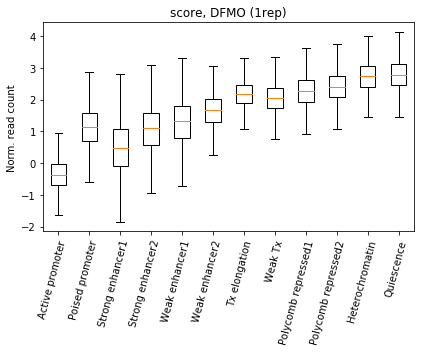

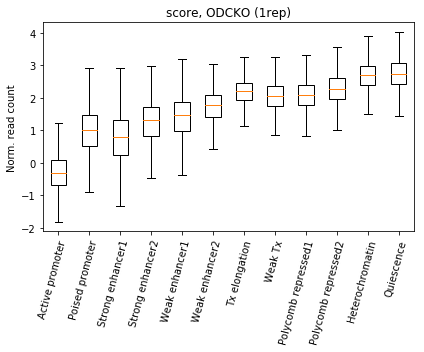

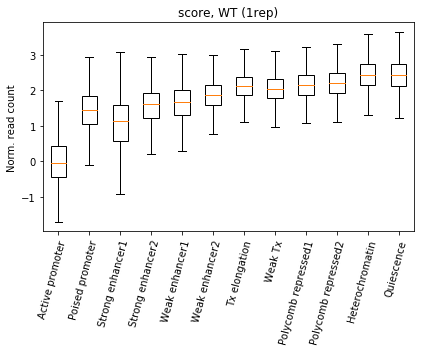

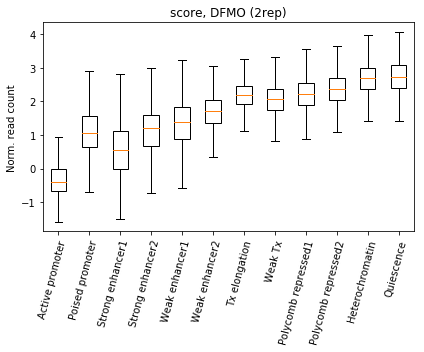

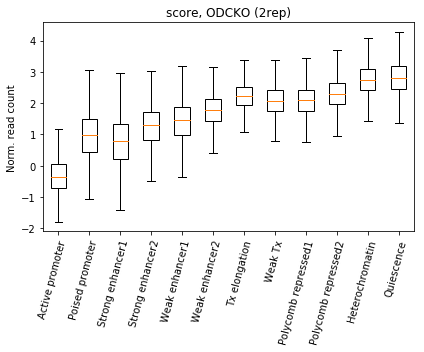

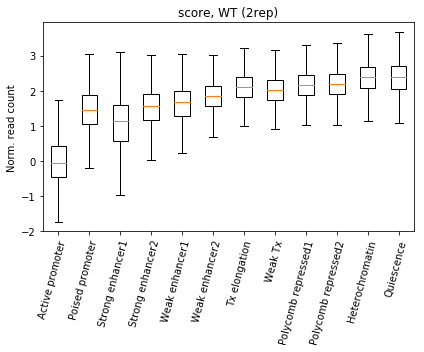

In [43]:
### plot the chromHMM
for dkey in sorted(dkey_state_values):
    state_values = dkey_state_values[dkey]

    graphics.plot_boxplot (state_values,
                           keys = mCD8T_states,
                           fig_width=6,
                           fig_height=5,
                           ylabel='Norm. read count',
                           title='%s, %s (%drep)' % (dkey[2], dkey[1].split(':')[1], dkey[0]),
                           rotation=75,
                           note='%s, %s (%drep)' % (dkey[2], dkey[1].split(':')[1], dkey[0]),
                           save=False)
    print
    

In [50]:
### plot multiple chromHMM (single nucleosome)
#marks = ['H3K27ac', 'H3K27me3']
marks = ['score']
reps = [1, 2]
for mark in marks:
    for rep in reps:
        graphics.plot_boxplot_multiple ([dkey_state_values[(rep, 'mCD8T:WT', mark)],
                                         dkey_state_values[(rep, 'mCD8T:DFMO', mark)]],
                                        keys=mCD8T_states,
                                        ylabel='Condensability score (A.U.)',
                                        title='%s, WT vs +DFMO (%drep)' % (mark, rep),
                                        rotation=45,
                                        colors=['tab:blue',
                                                'tab:orange'],
                                        labels=['WT',
                                                '+DFMO'],
                                        legend_loc='best',
                                        save=True,
                                        note='%s_WTvs+DFMO_%drep' % (mark, rep))
        print

In [51]:
### plot multiple chromHMM (single nucleosome)
#marks = ['H3K27ac', 'H3K27me3']
marks = ['score']
reps = [1, 2]
for mark in marks:
    for rep in reps:
        graphics.plot_boxplot_multiple ([dkey_state_values[(rep, 'mCD8T:WT', mark)],
                                         dkey_state_values[(rep, 'mCD8T:DFMO', mark)],
                                         dkey_state_values[(rep, 'mCD8T:ODCKO', mark)]],
                                        keys=mCD8T_states,
                                        ylabel='Condensability score (A.U.)',
                                        title='%s, WT vs +DFMO vs ODCKO (%drep)' % (mark, rep),
                                        rotation=45,
                                        colors=['tab:blue',
                                                'tab:orange',
                                                'tab:green'],
                                        labels=['WT',
                                                '+DFMO',
                                                'ODC-KO'],
                                        legend_loc='best',
                                        save=True,
                                        note='%s_WTvs+DFMOvsODCKO_%drep' % (mark, rep))
        print

In [45]:
### statistical testing for comparing two conditions
#reps = [1,2,3]
#marks = ['H3K27ac', 'H3K27me3']
reps = [1, 2]
marks = ['score']
dkey_testing_state_pvalue = {}
for testing in ['ttest']:
    for rep in reps:
        for mark in marks:
            dkey1 = (rep, 'mCD8T:WT', mark)
            dkey2 = (rep, 'mCD8T:DFMO', mark)

            state_IDs1 = dkey_state_IDs[dkey1]
            chr_ID_value1 = dkey_chr_ID_value[dkey1]
            state_values1 = {}
            for state, IDs in state_IDs1.items():
                values1 = [chr_ID_value1[ID[0]][ID] for ID in IDs]
                if state not in state_values1:
                    state_values1[state] = []
                state_values1[state] += values1

            state_IDs2 = dkey_state_IDs[dkey2]
            chr_ID_value2 = dkey_chr_ID_value[dkey2]
            state_values2 = {}
            for state, IDs in state_IDs2.items():
                values2 = [chr_ID_value2[ID[0]][ID] for ID in IDs]
                if state not in state_values2:
                    state_values2[state] = []
                state_values2[state] += values2

            for state in mCD8T_states:
                values1 = state_values1[state]
                values2 = state_values2[state]
                
                if testing == 'ttest':
                    pvalue = stats.ttest_ind(values1, values2, equal_var=False)[1]
                elif testing == 'mannwhitneyu':
                    pvalue = stats.mannwhitneyu(values1, values2)[1]
                elif testing == 'kruskal':
                    pvalue = stats.kruskal(values1, values2)[1]

                if (rep, 'DFMOvsWT', mark) not in dkey_testing_state_pvalue:
                    dkey_testing_state_pvalue[(rep, 'DFMOvsWT', mark)] = {}
                if testing not in dkey_testing_state_pvalue[(rep, 'DFMOvsWT', mark)]:
                    dkey_testing_state_pvalue[(rep, 'DFMOvsWT', mark)][testing] = {}
                dkey_testing_state_pvalue[(rep, 'DFMOvsWT', mark)][testing][state] = pvalue
            

        

In [46]:

#for mark in ['H3K27ac', 'H3K27me3']:
for mark in ['score']:
    for rep in [1,2]:
        dkey = (rep, 'DFMOvsWT', mark)
        print dkey
        testing_state_pvalue = dkey_testing_state_pvalue[dkey]
        for testing in testing_state_pvalue:
            state_pvalue = testing_state_pvalue[testing]
            for state in mCD8T_states:
                pvalue = state_pvalue[state]
                #print state, pvalue
                if pvalue > 0.05:
                    print state, state_pvalue[state]
        print 

(1, 'DFMOvsWT', 'score')

(2, 'DFMOvsWT', 'score')



In [47]:
### statistical testing
testings = ['ttest', 'mannwhitneyu', 'kruskal']
dkey_testing_pair_pvalue = {}
for dkey in dkey_state_IDs:
    state_IDs = dkey_state_IDs[dkey]
    chr_ID_value = dkey_chr_ID_value[dkey]
    
    state_values = {}
    for state, IDs in state_IDs.items():
        values = [chr_ID_value[ID[0]][ID] for ID in IDs]
        if state not in state_values:
            state_values[state] = []
        state_values[state] += values

    cell = dkey[1]

    if cell == 'H1':
        states = H1_states
    elif cell == 'GM':
        states = GM_states
    elif cell == 'mCD8T':
        states = mCD8T_states

    testing_pair_pvalue = {}
    for i in range(len(states)-1):
        for j in range(i+1, len(states)):
            
            state1 = states[i]
            state2 = states[j]
            values1 = state_values[state1]
            values2 = state_values[state2]
            
            pair = (state1, state2)
            for testing in testings:
                if testing == 'ttest':
                    pvalue = stats.ttest_ind(values1, values2, equal_var=False)[1]
                elif testing == 'mannwhitneyu':
                    pvalue = stats.mannwhitneyu(values1, values2)[1]
                elif testing == 'kruskal':
                    pvalue = stats.kruskal(values1, values2)[1]

                if testing not in testing_pair_pvalue:
                    testing_pair_pvalue[testing] = {}
                
                assert pair not in testing_pair_pvalue[testing]
                testing_pair_pvalue[testing][pair] = pvalue

    dkey_testing_pair_pvalue[dkey] = testing_pair_pvalue

In [48]:
for dkey in dkey_state_IDs:
    state_IDs = dkey_state_IDs[dkey]
    cell = dkey[1]

    if cell == 'H1':
        states = H1_states
    elif cell == 'GM':
        states = GM_states
    elif cell == 'mCD8T':
        states = mCD8T_states

    print dkey

    for state in states:
        print state, np.log10(len(state_IDs[state]))
    

(2, 'mCD8T:ODCKO', 'score')
Active promoter 3.8317418336456384
Poised promoter 3.3109056293761414
Strong enhancer1 4.300204051252466
Strong enhancer2 3.4599952560473914
Weak enhancer1 4.5457152356963135
Weak enhancer2 3.915821787620399
Tx elongation 4.731677387670855
Weak Tx 5.141267864695261
Polycomb repressed1 4.550986177622661
Polycomb repressed2 5.422922900994496
Heterochromatin 3.8053649074664455
Quiescence 5.842745871120865
(2, 'mCD8T:WT', 'score')
Active promoter 3.821513528404773
Poised promoter 3.3057811512549824
Strong enhancer1 4.293053023427832
Strong enhancer2 3.455910240382743
Weak enhancer1 4.533250795605823
Weak enhancer2 3.9079485216122722
Tx elongation 4.723135374655964
Weak Tx 5.1328933738078115
Polycomb repressed1 4.543347759379176
Polycomb repressed2 5.4152956085120145
Heterochromatin 3.7932314470565207
Quiescence 5.831147695427906
(2, 'mCD8T:DFMO', 'score')
Active promoter 3.832381160247041
Poised promoter 3.31492005599242
Strong enhancer1 4.29924572803494
Strong 

('Active promoter', 'Poised promoter') 10.0
('Active promoter', 'Strong enhancer1') 10.0
('Active promoter', 'Strong enhancer2') 10.0
('Active promoter', 'Weak enhancer1') 10.0
('Active promoter', 'Weak enhancer2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Weak Tx') 10.0
('Active promoter', 'Polycomb repressed1') 10.0
('Active promoter', 'Polycomb repressed2') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Poised promoter', 'Strong enhancer1') 10.0
('Poised promoter', 'Strong enhancer2') 10.0
('Poised promoter', 'Weak enhancer1') 10.0
('Poised promoter', 'Weak enhancer2') 10.0
('Poised promoter', 'Tx elongation') 10.0
('Poised promoter', 'Weak Tx') 10.0
('Poised promoter', 'Polycomb repressed1') 10.0
('Poised promoter', 'Polycomb repressed2') 10.0
('Poised promoter', 'Heterochromatin') 10.0
('Poised promoter', 'Quiescence') 10.0
('Strong enhancer1', 'Strong enhancer2') 10.0
('Strong enhancer1', 'Weak enhancer1') 10.0


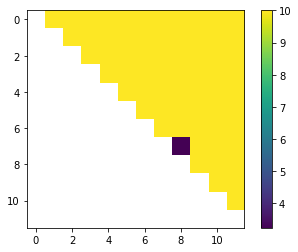

('Active promoter', 'Poised promoter')

 10.0
('Active promoter', 'Strong enhancer1') 10.0
('Active promoter', 'Strong enhancer2') 10.0
('Active promoter', 'Weak enhancer1') 10.0
('Active promoter', 'Weak enhancer2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Weak Tx') 10.0
('Active promoter', 'Polycomb repressed1') 10.0
('Active promoter', 'Polycomb repressed2') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Poised promoter', 'Strong enhancer1') 10.0
('Poised promoter', 'Strong enhancer2') 10.0
('Poised promoter', 'Weak enhancer1') 10.0
('Poised promoter', 'Weak enhancer2') 10.0
('Poised promoter', 'Tx elongation') 10.0
('Poised promoter', 'Weak Tx') 10.0
('Poised promoter', 'Polycomb repressed1') 10.0
('Poised promoter', 'Polycomb repressed2') 10.0
('Poised promoter', 'Heterochromatin') 10.0
('Poised promoter', 'Quiescence') 10.0
('Strong enhancer1', 'Strong enhancer2') 10.0
('Strong enhancer1', 'Weak enhancer1') 10.0
('Strong enhancer1', 'Weak enhancer2')

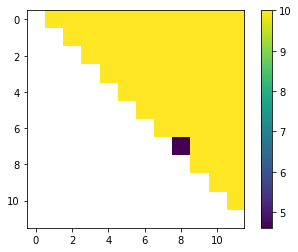

('Active promoter', 'Poised promoter') 10.0
('Active promoter', 'Strong enhancer1') 10.0
('Active promoter', 'Strong enhancer2') 10.0
('Active promoter', 'Weak enhancer1') 10.0
('Active promoter', 'Weak enhancer2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Weak Tx') 10.0
('Active promoter', 'Polycomb repressed1') 10.0
('Active promoter', 'Polycomb repressed2') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Poised promoter', 'Strong enhancer1') 10.0
('Poised promoter', 'Strong enhancer2') 10.0
('Poised promoter', 'Weak enhancer1') 10.0
('Poised promoter', 'Weak enhancer2') 10.0
('Poised promoter', 'Tx elongation') 10.0
('Poised promoter', 'Weak Tx') 10.0
('Poised promoter', 'Polycomb repressed1') 10.0
('Poised promoter', 'Polycomb repressed2') 10.0
('Poised promoter', 'Heterochromatin') 10.0
('Poised promoter', 'Quiescence') 10.0
('Strong enhancer1', 'Strong enhancer2') 10.0
('Strong enhancer1', 'Weak enhancer1') 10.0


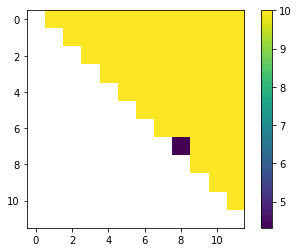

('Active promoter', 'Poised promoter') 10.0
('Active promoter', 'Strong enhancer1') 10.0
('Active promoter', 'Strong enhancer2') 10.0
('Active promoter', 'Weak enhancer1') 10.0
('Active promoter', 'Weak enhancer2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Weak Tx') 10.0
('Active promoter', 'Polycomb repressed1') 10.0
('Active promoter', 'Polycomb repressed2') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Poised promoter', 'Strong enhancer1') 10.0
('Poised promoter', 'Strong enhancer2') 4.0579749276884645
('Poised promoter', 'Weak enhancer1') 9.99999999999995
('Poised promoter', 'Weak enhancer2') 10.0
('Poised promoter', 'Tx elongation') 10.0
('Poised promoter', 'Weak Tx') 10.0
('Poised promoter', 'Polycomb repressed1') 10.0
('Poised promoter', 'Polycomb repressed2') 10.0
('Poised promoter', 'Heterochromatin') 10.0
('Poised promoter', 'Quiescence') 10.0
('Strong enhancer1', 'Strong enhancer2') 10.0
('Strong enhancer1

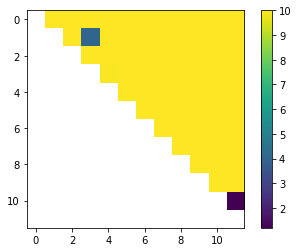

('Active promoter', 'Poised promoter') 10.0
('Active promoter', 'Strong enhancer1') 10.0
('Active promoter', 'Strong enhancer2') 10.0
('Active promoter', 'Weak enhancer1') 10.0
('Active promoter', 'Weak enhancer2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Weak Tx') 10.0
('Active promoter', 'Polycomb repressed1') 10.0
('Active promoter', 'Polycomb repressed2') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Poised promoter', 'Strong enhancer1') 10.0
('Poised promoter', 'Strong enhancer2') 5.066393445838273
('Poised promoter', 'Weak enhancer1') 10.0
('Poised promoter', 'Weak enhancer2') 10.0
('Poised promoter', 'Tx elongation') 10.0
('Poised promoter', 'Weak Tx') 10.0
('Poised promoter', 'Polycomb repressed1') 10.0
('Poised promoter', 'Polycomb repressed2') 10.0
('Poised promoter', 'Heterochromatin') 10.0
('Poised promoter', 'Quiescence') 10.0
('Strong enhancer1', 'Strong enhancer2') 10.0
('Strong enhancer1', 'Weak enha

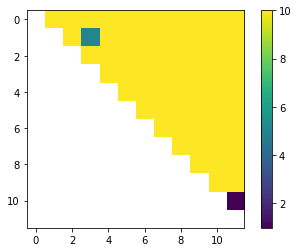

('Active promoter', 'Poised promoter') 10.0
('Active promoter', 'Strong enhancer1') 10.0
('Active promoter', 'Strong enhancer2') 10.0
('Active promoter', 'Weak enhancer1') 10.0
('Active promoter', 'Weak enhancer2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Weak Tx') 10.0
('Active promoter', 'Polycomb repressed1') 10.0
('Active promoter', 'Polycomb repressed2') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Poised promoter', 'Strong enhancer1')

 10.0
('Poised promoter', 'Strong enhancer2') 4.765386191474058
('Poised promoter', 'Weak enhancer1') 10.0
('Poised promoter', 'Weak enhancer2') 10.0
('Poised promoter', 'Tx elongation') 10.0
('Poised promoter', 'Weak Tx') 10.0
('Poised promoter', 'Polycomb repressed1') 10.0
('Poised promoter', 'Polycomb repressed2') 10.0
('Poised promoter', 'Heterochromatin') 10.0
('Poised promoter', 'Quiescence') 10.0
('Strong enhancer1', 'Strong enhancer2') 10.0
('Strong enhancer1', 'Weak enhancer1') 10.0
('Strong enhancer1', 'Weak enhancer2') 10.0
('Strong enhancer1', 'Tx elongation') 10.0
('Strong enhancer1', 'Weak Tx') 10.0
('Strong enhancer1', 'Polycomb repressed1') 10.0
('Strong enhancer1', 'Polycomb repressed2') 10.0
('Strong enhancer1', 'Heterochromatin') 10.0
('Strong enhancer1', 'Quiescence') 10.0
('Strong enhancer2', 'Weak enhancer1') 9.999989328255507
('Strong enhancer2', 'Weak enhancer2') 10.0
('Strong enhancer2', 'Tx elongation') 10.0
('Strong enhancer2', 'Weak Tx') 10.0
('Strong enhanc

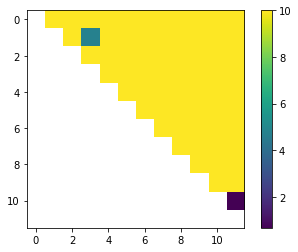

('Active promoter', 'Poised promoter') 10.0
('Active promoter', 'Strong enhancer1') 10.0
('Active promoter', 'Strong enhancer2') 10.0
('Active promoter', 'Weak enhancer1') 10.0
('Active promoter', 'Weak enhancer2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Weak Tx') 10.0
('Active promoter', 'Polycomb repressed1') 10.0
('Active promoter', 'Polycomb repressed2') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Poised promoter', 'Strong enhancer1') 10.0
('Poised promoter', 'Strong enhancer2') 0.26829843813388343
('Poised promoter', 'Weak enhancer1') 10.0
('Poised promoter', 'Weak enhancer2') 10.0
('Poised promoter', 'Tx elongation') 10.0
('Poised promoter', 'Weak Tx') 10.0
('Poised promoter', 'Polycomb repressed1') 10.0
('Poised promoter', 'Polycomb repressed2') 10.0
('Poised promoter', 'Heterochromatin') 10.0
('Poised promoter', 'Quiescence') 10.0
('Strong enhancer1', 'Strong enhancer2') 10.0
('Strong enhancer1', 'Weak en

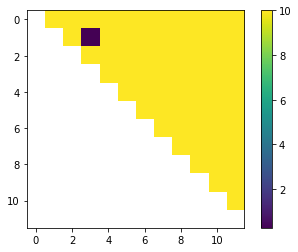

('Active promoter', 'Poised promoter') 10.0
('Active promoter', 'Strong enhancer1') 10.0
('Active promoter', 'Strong enhancer2') 10.0
('Active promoter', 'Weak enhancer1') 10.0
('Active promoter', 'Weak enhancer2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Weak Tx') 10.0
('Active promoter', 'Polycomb repressed1') 10.0
('Active promoter', 'Polycomb repressed2') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Poised promoter', 'Strong enhancer1') 10.0
('Poised promoter', 'Strong enhancer2') 1.4384937822925457
('Poised promoter', 'Weak enhancer1') 10.0
('Poised promoter', 'Weak enhancer2') 10.0
('Poised promoter', 'Tx elongation') 10.0
('Poised promoter', 'Weak Tx') 10.0
('Poised promoter', 'Polycomb repressed1') 10.0
('Poised promoter', 'Polycomb repressed2') 10.0
('Poised promoter', 'Heterochromatin') 10.0
('Poised promoter', 'Quiescence') 10.0


('Strong enhancer1', 'Strong enhancer2') 10.0
('Strong enhancer1', 'Weak enhancer1') 10.0
('Strong enhancer1', 'Weak enhancer2') 10.0
('Strong enhancer1', 'Tx elongation') 10.0
('Strong enhancer1', 'Weak Tx') 10.0
('Strong enhancer1', 'Polycomb repressed1') 10.0
('Strong enhancer1', 'Polycomb repressed2') 10.0
('Strong enhancer1', 'Heterochromatin') 10.0
('Strong enhancer1', 'Quiescence') 10.0
('Strong enhancer2', 'Weak enhancer1') 10.0
('Strong enhancer2', 'Weak enhancer2') 10.0
('Strong enhancer2', 'Tx elongation') 10.0
('Strong enhancer2', 'Weak Tx') 10.0
('Strong enhancer2', 'Polycomb repressed1') 10.0
('Strong enhancer2', 'Polycomb repressed2') 10.0
('Strong enhancer2', 'Heterochromatin') 10.0
('Strong enhancer2', 'Quiescence') 10.0
('Weak enhancer1', 'Weak enhancer2') 10.0
('Weak enhancer1', 'Tx elongation') 10.0
('Weak enhancer1', 'Weak Tx') 10.0
('Weak enhancer1', 'Polycomb repressed1') 10.0
('Weak enhancer1', 'Polycomb repressed2') 10.0
('Weak enhancer1', 'Heterochromatin') 1

('Weak enhancer2', 'Polycomb repressed2') 10.0
('Weak enhancer2', 'Heterochromatin') 10.0
('Weak enhancer2', 'Quiescence') 10.0
('Tx elongation', 'Weak Tx') 10.0
('Tx elongation', 'Polycomb repressed1') 10.0
('Tx elongation', 'Polycomb repressed2') 10.0
('Tx elongation', 'Heterochromatin') 10.0
('Tx elongation', 'Quiescence') 10.0
('Weak Tx', 'Polycomb repressed1') 10.0
('Weak Tx', 'Polycomb repressed2') 10.0
('Weak Tx', 'Heterochromatin') 10.0
('Weak Tx', 'Quiescence') 10.0
('Polycomb repressed1', 'Polycomb repressed2') 10.0
('Polycomb repressed1', 'Heterochromatin') 10.0
('Polycomb repressed1', 'Quiescence') 10.0
('Polycomb repressed2', 'Heterochromatin') 10.0
('Polycomb repressed2', 'Quiescence') 10.0
('Heterochromatin', 'Quiescence') 9.994903385279324
mannwhitneyu


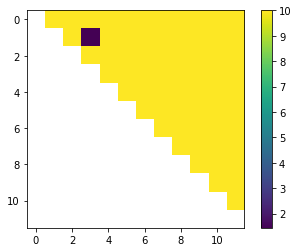

('Active promoter', 'Poised promoter') 10.0
('Active promoter', 'Strong enhancer1') 10.0
('Active promoter', 'Strong enhancer2') 10.0
('Active promoter', 'Weak enhancer1') 10.0
('Active promoter', 'Weak enhancer2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Weak Tx') 10.0
('Active promoter', 'Polycomb repressed1') 10.0
('Active promoter', 'Polycomb repressed2') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Poised promoter', 'Strong enhancer1') 10.0
('Poised promoter', 'Strong enhancer2') 1.1374733896720208
('Poised promoter', 'Weak enhancer1') 10.0
('Poised promoter', 'Weak enhancer2') 10.0
('Poised promoter', 'Tx elongation') 10.0
('Poised promoter', 'Weak Tx') 10.0
('Poised promoter', 'Polycomb repressed1') 10.0
('Poised promoter', 'Polycomb repressed2') 10.0
('Poised promoter', 'Heterochromatin') 10.0
('Poised promoter', 'Quiescence') 10.0
('Strong enhancer1', 'Strong enhancer2') 10.0
('Strong enhancer1', 'Weak enh

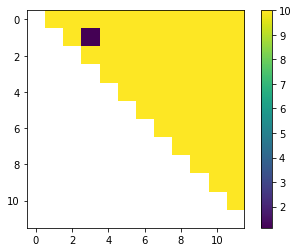

('Active promoter', 'Poised promoter') 10.0
('Active promoter', 'Strong enhancer1') 10.0
('Active promoter', 'Strong enhancer2') 10.0
('Active promoter', 'Weak enhancer1') 10.0
('Active promoter', 'Weak enhancer2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Weak Tx') 10.0
('Active promoter', 'Polycomb repressed1') 10.0
('Active promoter', 'Polycomb repressed2') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Poised promoter', 'Strong enhancer1') 10.0
('Poised promoter', 'Strong enhancer2') 10.0
('Poised promoter', 'Weak enhancer1') 10.0
('Poised promoter', 'Weak enhancer2') 10.0
('Poised promoter', 'Tx elongation') 10.0
('Poised promoter', 'Weak Tx') 10.0
('Poised promoter', 'Polycomb repressed1') 10.0
('Poised promoter', 'Polycomb repressed2') 10.0
('Poised promoter', 'Heterochromatin') 10.0
('Poised promoter', 'Quiescence') 10.0
('Strong enhancer1', 'Strong enhancer2') 10.0
('Strong enhancer1', 'Weak enhancer1') 10.0


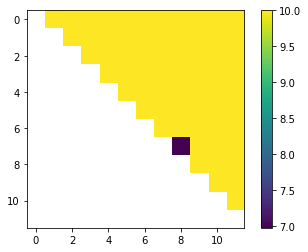

('Active promoter', 'Poised promoter') 10.0
('Active promoter', 'Strong enhancer1') 10.0
('Active promoter', 'Strong enhancer2') 10.0
('Active promoter', 'Weak enhancer1') 10.0
('Active promoter', 'Weak enhancer2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Weak Tx') 10.0
('Active promoter', 'Polycomb repressed1') 10.0
('Active promoter', 'Polycomb repressed2') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Poised promoter', 'Strong enhancer1') 10.0
('Poised promoter', 'Strong enhancer2') 10.0
('Poised promoter', 'Weak enhancer1') 10.0
('Poised promoter', 'Weak enhancer2') 10.0
('Poised promoter', 'Tx elongation') 10.0
('Poised promoter', 'Weak Tx') 10.0
('Poised promoter', 'Polycomb repressed1') 10.0
('Poised promoter', 'Polycomb repressed2') 10.0
('Poised promoter', 'Heterochromatin') 10.0
('Poised promoter', 'Quiescence') 10.0
('Strong enhancer1', 'Strong enhancer2') 10.0
('Strong enhancer1', 'Weak enhancer1') 10.0


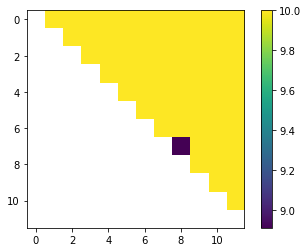

('Active promoter', 'Poised promoter') 10.0
('Active promoter', 'Strong enhancer1') 10.0
('Active promoter', 'Strong enhancer2') 10.0
('Active promoter', 'Weak enhancer1') 10.0
('Active promoter', 'Weak enhancer2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Weak Tx') 10.0
('Active promoter', 'Polycomb repressed1') 10.0
('Active promoter', 'Polycomb repressed2') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Poised promoter', 'Strong enhancer1') 10.0
('Poised promoter', 'Strong enhancer2') 10.0
('Poised promoter', 'Weak enhancer1') 10.0
('Poised promoter', 'Weak enhancer2') 10.0
('Poised promoter', 'Tx elongation') 10.0
('Poised promoter', 'Weak Tx') 10.0
('Poised promoter', 'Polycomb repressed1') 10.0
('Poised promoter', 'Polycomb repressed2') 10.0
('Poised promoter', 'Heterochromatin') 10.0
('Poised promoter', 'Quiescence') 10.0
('Strong enhancer1', 'Strong enhancer2') 10.0
('Strong enhancer1', 'Weak enhancer1') 10.0


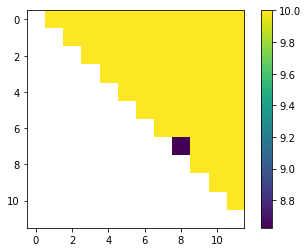

('Active promoter', 'Poised promoter') 10.0
('Active promoter', 'Strong enhancer1') 10.0
('Active promoter', 'Strong enhancer2') 10.0
('Active promoter', 'Weak enhancer1') 10.0
('Active promoter', 'Weak enhancer2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Weak Tx') 10.0
('Active promoter', 'Polycomb repressed1') 10.0
('Active promoter', 'Polycomb repressed2') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Poised promoter', 'Strong enhancer1') 10.0
('Poised promoter', 'Strong enhancer2') 8.020787083499023
('Poised promoter', 'Weak enhancer1') 9.959603108452905
('Poised promoter', 'Weak enhancer2') 10.0
('Poised promoter', 'Tx elongation') 10.0
('Poised promoter', 'Weak Tx') 10.0
('Poised promoter', 'Polycomb repressed1') 10.0
('Poised promoter', 'Polycomb repressed2') 10.0
('Poised promoter', 'Heterochromatin') 10.0
('Poised promoter', 'Quiescence') 10.0
('Strong enhancer1', 'Strong enhancer2') 10.0
('Strong enhancer1

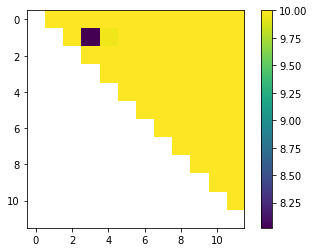

('Active promoter', 'Poised promoter') 10.0
('Active promoter', 'Strong enhancer1') 10.0
('Active promoter', 'Strong enhancer2') 10.0
('Active promoter', 'Weak enhancer1') 10.0
('Active promoter', 'Weak enhancer2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Weak Tx') 10.0
('Active promoter', 'Polycomb repressed1') 10.0
('Active promoter', 'Polycomb repressed2') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Poised promoter', 'Strong enhancer1') 10.0
('Poised promoter', 'Strong enhancer2') 3.6477929008737617
('Poised promoter', 'Weak enhancer1') 9.999999999969507
('Poised promoter', 'Weak enhancer2') 10.0
('Poised promoter', 'Tx elongation') 10.0
('Poised promoter', 'Weak Tx') 10.0
('Poised promoter', 'Polycomb repressed1') 10.0
('Poised promoter', 'Polycomb repressed2') 10.0
('Poised promoter', 'Heterochromatin') 10.0
('Poised promoter', 'Quiescence') 10.0
('Strong enhancer1', 'Strong enhancer2') 10.0
('Strong enhancer

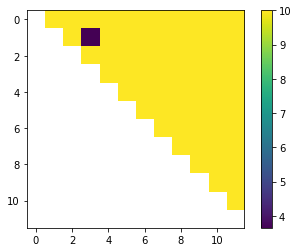

('Active promoter', 'Poised promoter') 10.0
('Active promoter', 'Strong enhancer1') 10.0
('Active promoter', 'Strong enhancer2') 10.0
('Active promoter', 'Weak enhancer1') 10.0
('Active promoter', 'Weak enhancer2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Weak Tx') 10.0
('Active promoter', 'Polycomb repressed1') 10.0
('Active promoter', 'Polycomb repressed2') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Poised promoter', 'Strong enhancer1') 10.0
('Poised promoter', 'Strong enhancer2') 3.3467795030627405
('Poised promoter', 'Weak enhancer1') 9.999999999939014
('Poised promoter', 'Weak enhancer2') 10.0
('Poised promoter', 'Tx elongation') 10.0
('Poised promoter', 'Weak Tx') 10.0
('Poised promoter', 'Polycomb repressed1') 10.0
('Poised promoter', 'Polycomb repressed2') 10.0
('Poised promoter', 'Heterochromatin') 10.0
('Poised promoter', 'Quiescence') 10.0
('Strong enhancer1', 'Strong enhancer2') 10.0
('Strong enhancer

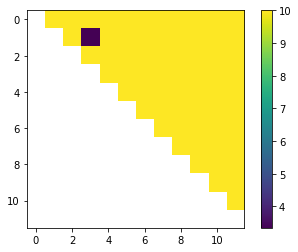

('Active promoter', 'Poised promoter') 10.0
('Active promoter', 'Strong enhancer1') 10.0
('Active promoter', 'Strong enhancer2') 10.0
('Active promoter', 'Weak enhancer1') 10.0
('Active promoter', 'Weak enhancer2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Weak Tx') 10.0
('Active promoter', 'Polycomb repressed1') 10.0
('Active promoter', 'Polycomb repressed2') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Poised promoter', 'Strong enhancer1') 10.0
('Poised promoter', 'Strong enhancer2') 9.992568741147364
('Poised promoter', 'Weak enhancer1') 10.0
('Poised promoter', 'Weak enhancer2') 10.0
('Poised promoter', 'Tx elongation') 10.0
('Poised promoter', 'Weak Tx') 10.0
('Poised promoter', 'Polycomb repressed1') 10.0
('Poised promoter', 'Polycomb repressed2') 10.0
('Poised promoter', 'Heterochromatin') 10.0
('Poised promoter', 'Quiescence') 10.0
('Strong enhancer1', 'Strong enhancer2') 10.0
('Strong enhancer1', 'Weak enha

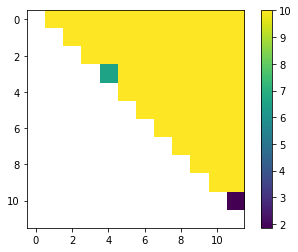

('Active promoter', 'Poised promoter') 10.0
('Active promoter', 'Strong enhancer1') 10.0
('Active promoter', 'Strong enhancer2') 10.0
('Active promoter', 'Weak enhancer1') 10.0
('Active promoter', 'Weak enhancer2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Weak Tx') 10.0
('Active promoter', 'Polycomb repressed1') 10.0
('Active promoter', 'Polycomb repressed2') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Poised promoter', 'Strong enhancer1') 10.0
('Poised promoter', 'Strong enhancer2') 9.999926642022489
('Poised promoter', 'Weak enhancer1') 10.0
('Poised promoter', 'Weak enhancer2') 10.0
('Poised promoter', 'Tx elongation') 10.0
('Poised promoter', 'Weak Tx') 10.0
('Poised promoter', 'Polycomb repressed1') 10.0
('Poised promoter', 'Polycomb repressed2') 10.0
('Poised promoter', 'Heterochromatin') 10.0
('Poised promoter', 'Quiescence') 10.0
('Strong enhancer1', 'Strong enhancer2') 10.0
('Strong enhancer1', 'Weak enha

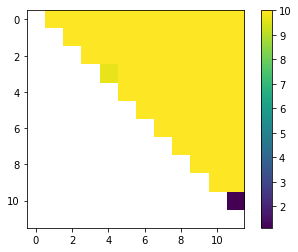

('Active promoter', 'Poised promoter') 10.0
('Active promoter', 'Strong enhancer1') 10.0
('Active promoter', 'Strong enhancer2') 10.0
('Active promoter', 'Weak enhancer1') 10.0
('Active promoter', 'Weak enhancer2') 10.0
('Active promoter', 'Tx elongation') 10.0
('Active promoter', 'Weak Tx') 10.0
('Active promoter', 'Polycomb repressed1') 10.0
('Active promoter', 'Polycomb repressed2') 10.0
('Active promoter', 'Heterochromatin') 10.0
('Active promoter', 'Quiescence') 10.0
('Poised promoter', 'Strong enhancer1') 10.0
('Poised promoter', 'Strong enhancer2') 9.999853307953213
('Poised promoter', 'Weak enhancer1') 10.0
('Poised promoter', 'Weak enhancer2') 10.0
('Poised promoter', 'Tx elongation') 10.0
('Poised promoter', 'Weak Tx') 10.0
('Poised promoter', 'Polycomb repressed1') 10.0
('Poised promoter', 'Polycomb repressed2') 10.0
('Poised promoter', 'Heterochromatin') 10.0
('Poised promoter', 'Quiescence') 10.0
('Strong enhancer1', 'Strong enhancer2') 10.0
('Strong enhancer1', 'Weak enha

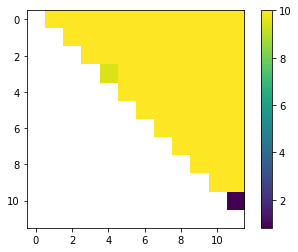

In [49]:
for dkey in dkey_testing_pair_pvalue:
    for testing in testings:
        pair_pvalue = dkey_testing_pair_pvalue[dkey][testing]
        cell = dkey[1]

        if cell == 'H1':
            states = H1_states
        elif cell == 'GM':
            states = GM_states
        elif cell == 'mCD8T':
            states = mCD8T_states

        img = []
        for i in range(len(states)):
            row = []
            for j in range(len(states)):
                try:
                    pair = (states[i], states[j])
                    pvalue = pair_pvalue[pair] + 10**-10
                    logpvalue = -np.log10(pvalue)
                    print pair, logpvalue
                except:
                    logpvalue = np.nan
                row.append(logpvalue)
            img.append(row)

        print testing

        fig = plt.figure()
        plt.imshow(img)
        plt.colorbar()
        plt.show()
        plt.close()
        